In [1]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
path =  Path(os.path.abspath("")).parent.absolute()
print(path)
sys.path.append(path)
save_folder = os.path.join(path, 'figures/')
import pickle
import matplotlib.pyplot as plt
import copy
import torch
from datetime import timedelta, datetime
import matplotlib.dates as mdates

import sys
sys.path.append('../../../')
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import os
import GAMCR

def filter_dates(dates, site, all_data=False):
    dates = pd.to_datetime(dates)
    if not(all_data):
        idxsyear = np.where(np.array([date.year for date in dates])>=2018)[0]
    if site == '46':
        low_month = 7
        up_month = 9
    elif site in ['3','44','112']:
        low_month = 6
        up_month = 10
    else:
        low_month = 5
        up_month = 10
    idxsmonth_low = np.where(np.array([date.month for date in dates])>=low_month)[0]
    #np.where(dates.apply(lambda x: x.month>=low_month))[0]
    #idxsmonth_up = np.where(dates.apply(lambda x: x.month<=up_month))[0]
    idxsmonth_up = np.where(np.array([date.month for date in dates])<=up_month)[0]
    if not(all_data):
        idxs = np.intersect1d(idxsyear, idxsmonth_low)
    else:
        idxs = idxsmonth_low
    idxs = np.intersect1d(idxs, idxsmonth_up)
    return idxs


def nse(observed, simulated):
    """
    Calculate the Nash-Sutcliffe Efficiency (NSE).
    
    Parameters:
    observed (array-like): Array of observed values.
    simulated (array-like): Array of simulated values.
    
    Returns:
    float: NSE value.
    """
    observed = np.array(observed)
    simulated = np.array(simulated)
    
    # Calculate the mean of the observed data
    mean_observed = np.mean(observed)
    
    # Compute the numerator and denominator of the NSE formula
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - mean_observed) ** 2)
    
    # Compute NSE
    nse_value = 1 - (numerator / denominator)
    
    return nse_value


import matplotlib.cm as cm
import colorsys
def rainbow_colors(K = 10):
    colors = cm.rainbow(np.linspace(0, 1, K))
    # Reduce brightness by converting RGB to HSV and adjusting Value (V)
    adjusted_colors = []
    for color in colors:
        r, g, b, _ = color
        h, s, v = colorsys.rgb_to_hsv(r, g, b)
        v = v * 0.7  # Reduce brightness to 70% of original
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        adjusted_colors.append((r, g, b))
    return adjusted_colors


log_mode = False

from get_data_from_ERRA import *
path_ERRA = os.path.join(path, 'data_and_visualization', 'output_ERRA_forGAMCR')
dicERRA = get_data_from_ERRA(path_ERRA)
#all_GISID = list(dicERRA.keys())
all_GISID = [el for el in list(os.walk(path))[0][1] if not any(c in el for c in ['/', '.', '_'])]
colors = rainbow_colors(len(all_GISID))

/home/duchemin/Documents/GAMCR/experiments/real_data


# Weighted RRDs for GAMCR and ERRA: all sites on the same figure

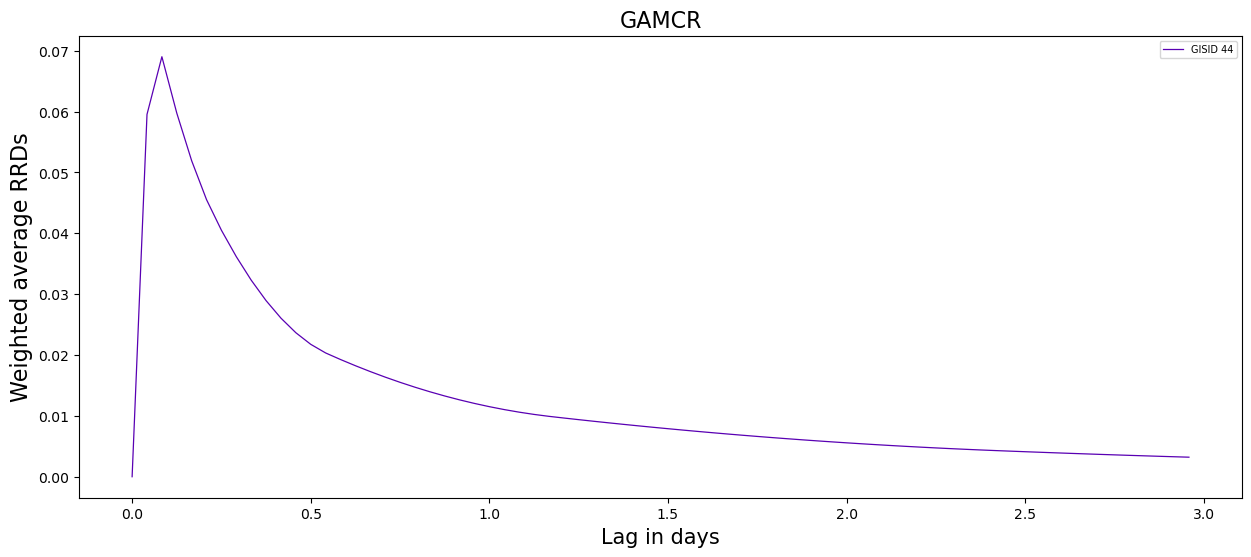

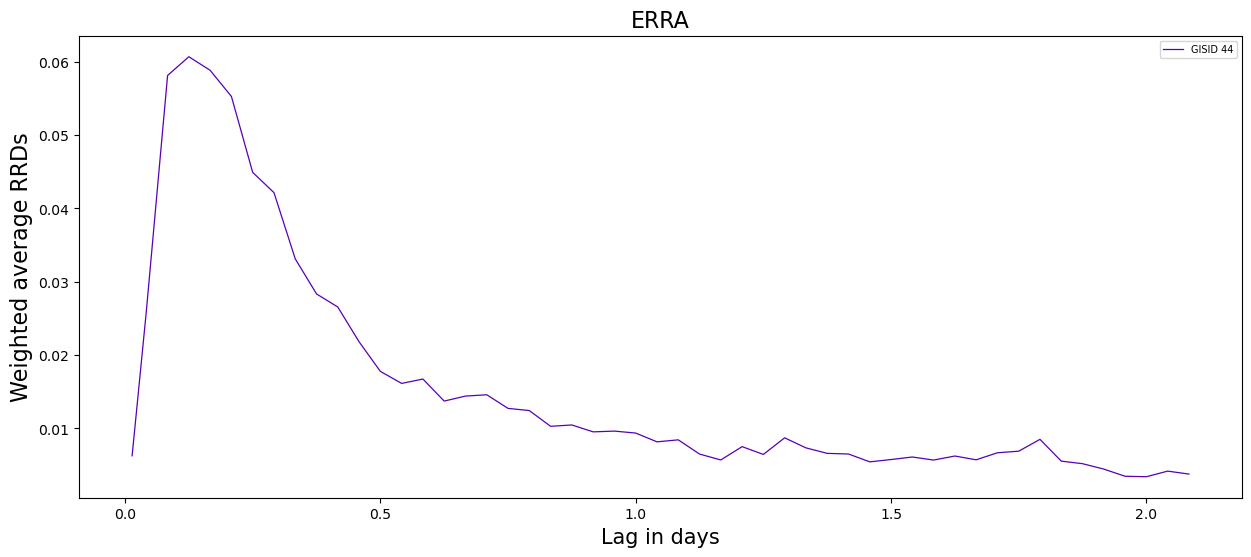

In [2]:
from datetime import datetime
for method in ['GAMCR', 'ERRA']:
    fig, axs = plt.subplots(1, 1, figsize=(15,6))
    for ii in range(len(all_GISID)):
        GISID = all_GISID[ii]
        wavgRRD = np.load(os.path.join(path, GISID, 'results', 'detailedresults', 'weighted_avg_RRD.npy')).reshape(-1)
    
        ########## Transfer functions
        maxlag = 24*3
        lagsERRA = dicERRA[GISID]['lagtime_RRD']
        if lagsERRA[-1]<=maxlag:
            idx_erra = len(lagsERRA)
        else:
            idx_erra = np.where(lagsERRA<=maxlag)[0][-1]
        # Estimated global transfer function using the model trained on the site considered
        if log_mode:
            if method=='GAMCR':
                axs.plot([i/24 for i in range(maxlag)], np.log(wavgRRD[:maxlag]), color=colors[ii], label='GISID {0}'.format(GISID),  lw=0.9)
            else:
                axs.plot(dicERRA[GISID]['lagtime_RRD'][:idx_erra]/24, np.log(dicERRA[GISID]['wtd_avg_RRD_p'][:idx_erra]), color=colors[ii], label='GISID {0}'.format(GISID), lw=0.9)
        else:
            if method=='GAMCR':
                axs.plot([i/24 for i in range(maxlag)], wavgRRD[:maxlag], color=colors[ii], label='GISID {0}'.format(GISID),  lw=0.9)
            else:
                axs.plot(dicERRA[GISID]['lagtime_RRD'][:idx_erra]/24, dicERRA[GISID]['wtd_avg_RRD_p'][:idx_erra], color=colors[ii], label='GISID {0}'.format(GISID), lw=0.9)
        axs.legend(loc='upper right', fontsize=7)
    plt.title(method, fontsize=16)
    plt.xlabel('Lag in days', fontsize=15)
    plt.ylabel('Weighted average RRDs', fontsize=16)

# GAMCR NRF heights vs precipitation intensity

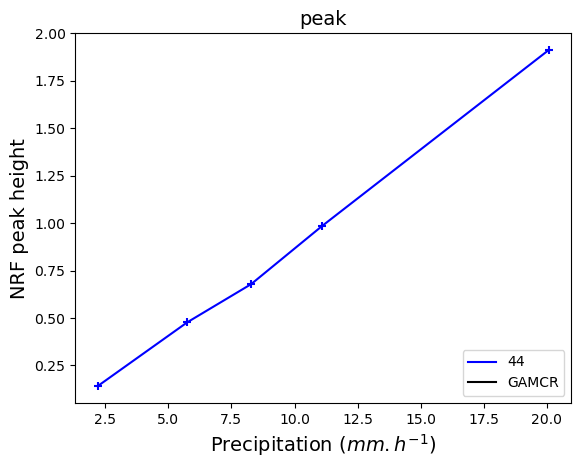

In [3]:
GAMCR.resultsanalysis.show_vs_precip_intensity(path, all_GISID, weighted=True, log_ordo=False, dataERRA=None, stats2show=['peak'])

# ERRA NRF heights vs precipitation intensity

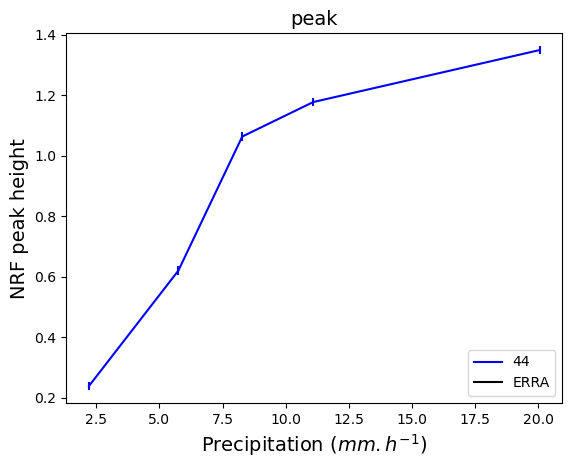

In [4]:
GAMCR.resultsanalysis.show_vs_precip_intensity(path, all_GISID, weighted=True, log_ordo=False, dataERRA=dicERRA, show_GAMCR=False, stats2show=['peak'])

# Reproduced hydrographs on the test set

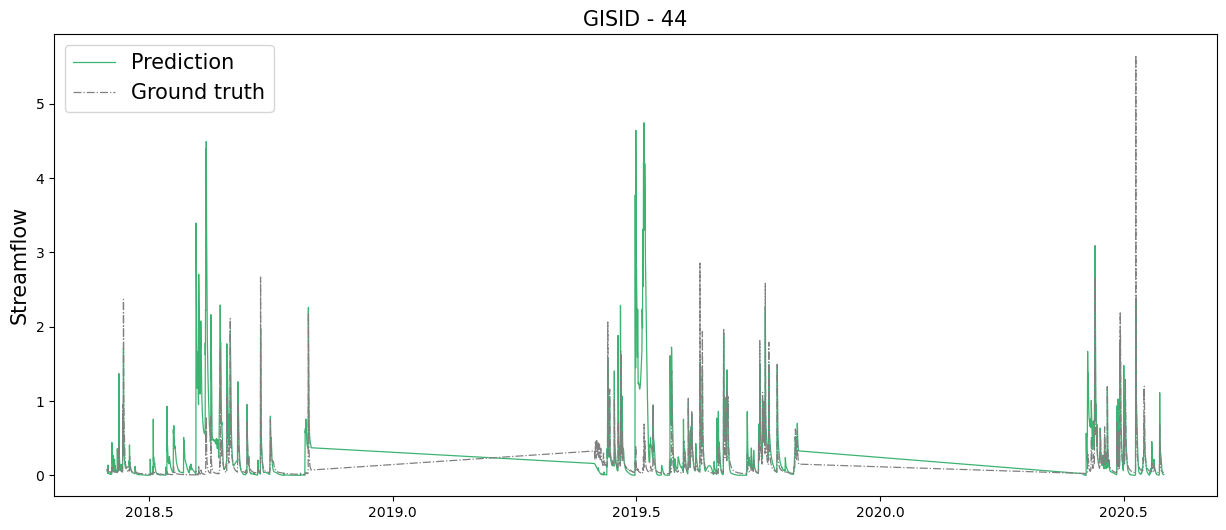

In [5]:
for ii in range(len(all_GISID)):
    GISID = all_GISID[ii]
    fig, axs = plt.subplots(1, 1, figsize=(15,6))
    df = pd.read_csv(os.path.join(path, GISID, 'data_'+GISID+'.txt'))
    idxs = filter_dates(df['date'].to_numpy(), GISID)
    Qtrue = df.iloc[idxs]['q'].to_numpy()
    
    dates_true = df.iloc[idxs]['timeyear'].to_numpy()
    Qhat = np.load(os.path.join(path, GISID, 'results/detailedresults', 'predicted_streamflow.npy')).reshape(-1)
    
    dates = np.load(os.path.join(path, GISID, 'results/detailedresults', 'dates.npy')).reshape(-1)
    
    idxs = np.where(dates>2018)
    ########## Streamflow time series
    # Estimated streamflow using the model trained on the site considered
    axs.plot(dates[idxs], Qhat[idxs], label='Prediction', lw=0.9, color='mediumseagreen')
    axs.plot(dates_true, Qtrue, label='Ground truth', lw=0.9, linestyle='-.', color='grey')
    axs.legend(loc='upper left', fontsize=15)
    plt.title('GISID - {0}'.format(GISID), fontsize=15)
    plt.ylabel('Streamflow', fontsize=15)
    plt.show()
#    axs.text(.01, .70, 'NSE: {:.3f}'.format(nse( dico['Qhat'], dico['Qtrue'] )), size=10,color='grey',ha='left', va='top', transform=axs[0,0].transAxes)

# LOG of the reproduced hydrographs

/tmp/ipykernel_13646/288712998.py:16: RuntimeWarning: divide by zero encountered in log10
  axs.plot(dates[idxs], np.log10(Qhat[idxs]), label='Prediction', lw=0.9, color='mediumseagreen')


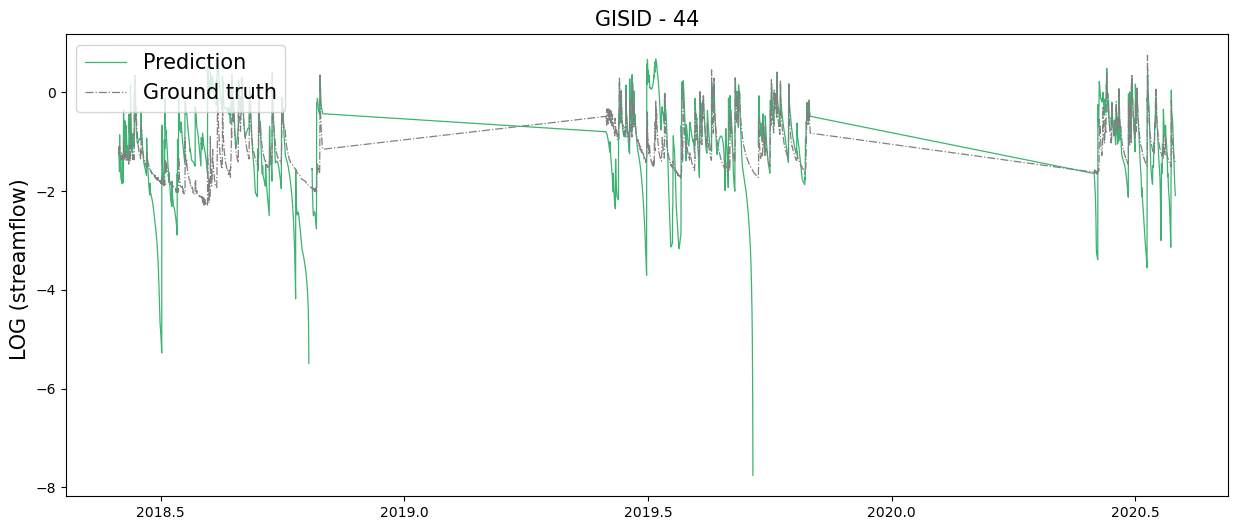

In [6]:
for ii in range(len(all_GISID)):
    GISID = all_GISID[ii]
    fig, axs = plt.subplots(1, 1, figsize=(15,6))
    df = pd.read_csv(os.path.join(path, GISID, 'data_'+GISID+'.txt'))
    idxs = filter_dates(df['date'].to_numpy(), GISID)
    Qtrue = df.iloc[idxs]['q'].to_numpy()
        
    dates_true = df.iloc[idxs]['timeyear'].to_numpy()
    Qhat = np.load(os.path.join(path, GISID, 'results/detailedresults', 'predicted_streamflow.npy')).reshape(-1)
    
    dates = np.load(os.path.join(path, GISID, 'results/detailedresults', 'dates.npy')).reshape(-1)
    
    idxs = np.where(dates>2018)
    ########## Streamflow time series
    # Estimated streamflow using the model trained on the site considered
    axs.plot(dates[idxs], np.log10(Qhat[idxs]), label='Prediction', lw=0.9, color='mediumseagreen')
    axs.plot(dates_true, np.log10(Qtrue), label='Ground truth', lw=0.9, linestyle='-.', color='grey')
    axs.legend(loc='upper left', fontsize=15)
    plt.title('GISID - {0}'.format(GISID), fontsize=15)
    plt.ylabel('LOG (streamflow) ', fontsize=15)
    plt.show()
#    axs.text(.01, .70, 'NSE: {:.3f}'.format(nse( dico['Qhat'], dico['Qtrue'] )), size=10,color='grey',ha='left', va='top', transform=axs[0,0].transAxes)

# NRF by precipitation quantiles

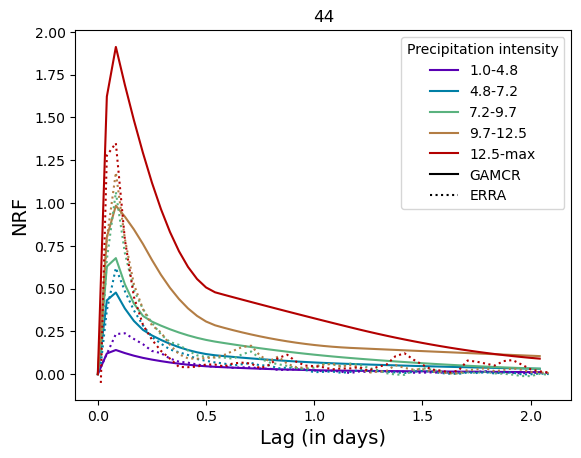

In [7]:
for site in all_GISID:
    site_folder = os.path.join(path, site)
    GAMCR.resultsanalysis.show_tf_p_or_q(site_folder, site, dataERRA=dicERRA[site], stratif_wetness=False, maxT=24*10, weighted=True)#, figname='NRF_quantiles_{0}'.format(site))

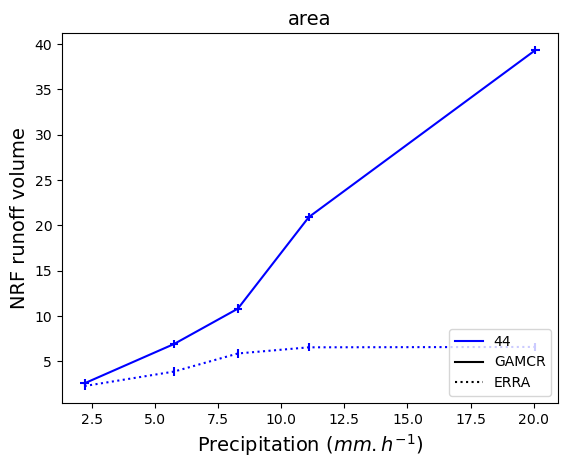

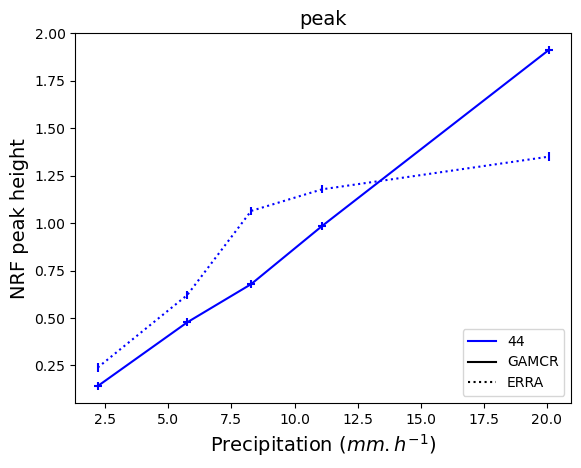

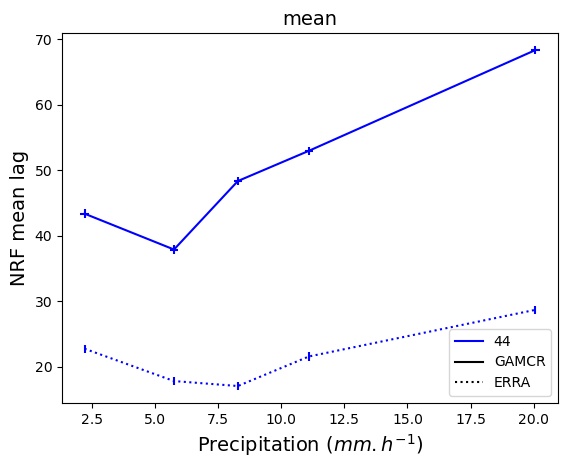

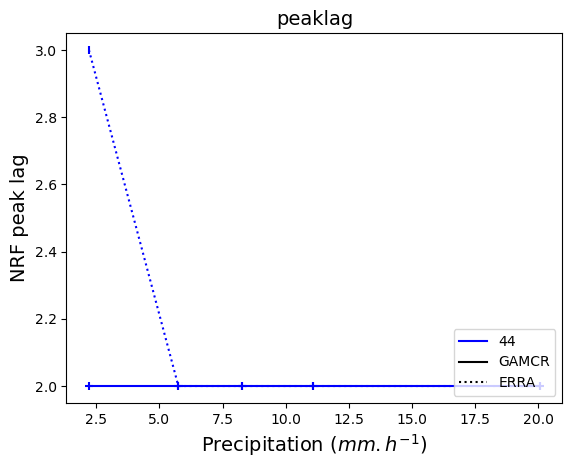

In [8]:
GAMCR.resultsanalysis.show_vs_precip_intensity(path, all_GISID, weighted=True, log_ordo=False, dataERRA=dicERRA)

# Weighted average RRD site by site

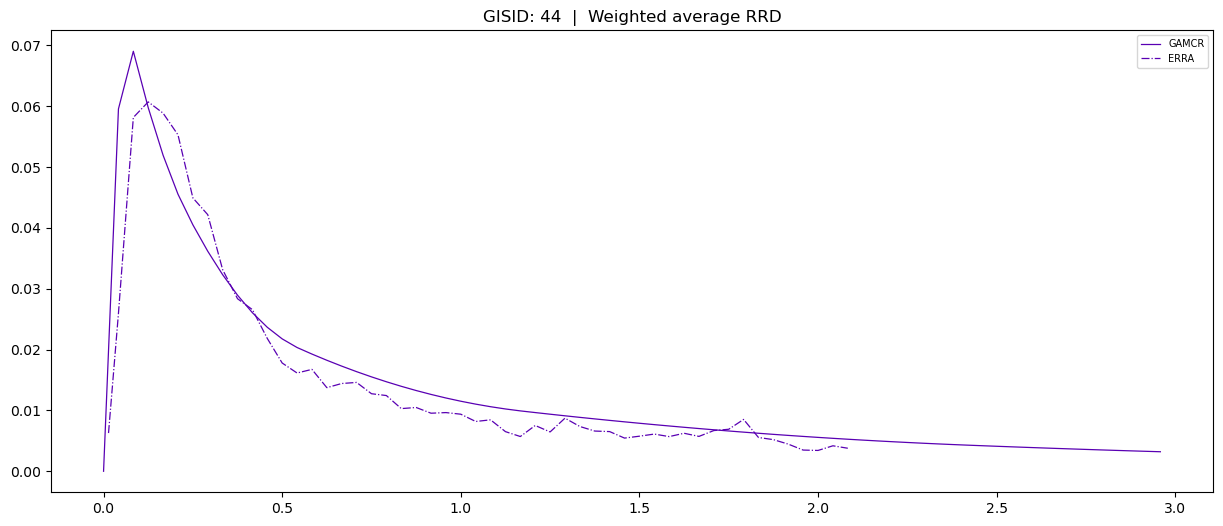

In [9]:
from datetime import datetime
for ii in range(len(all_GISID)):
    fig, axs = plt.subplots(1, 1, figsize=(15,6))


    GISID = all_GISID[ii]
    wavgRRD = np.load(os.path.join(path, GISID, 'results/detailedresults', 'weighted_avg_RRD.npy')).reshape(-1)

    ########## Transfer functions
    maxlag = 24*3
    lagsERRA = dicERRA[GISID]['lagtime_RRD']
    if lagsERRA[-1]<=maxlag:
        idx_erra = len(lagsERRA)
    else:
        idx_erra = np.where(lagsERRA<=maxlag)[0][-1]
    # Estimated global transfer function using the model trained on the site considered
    if log_mode:
        axs.plot([i/24 for i in range(maxlag)], np.log(wavgRRD[:maxlag]), color=colors[ii], label='GAMCR',  lw=0.9)
        axs.plot(dicERRA[GISID]['lagtime_RRD'][:idx_erra]/24, np.log(dicERRA[GISID]['wtd_avg_RRD_p'][:idx_erra]), color=colors[ii], label='ERRA', linestyle='-.', lw=0.9)
    else:
        axs.plot([i/24 for i in range(maxlag)], wavgRRD[:maxlag], color=colors[ii], label='GAMCR',  lw=0.9)
        axs.plot(dicERRA[GISID]['lagtime_RRD'][:idx_erra]/24, dicERRA[GISID]['wtd_avg_RRD_p'][:idx_erra], color=colors[ii], label='ERRA', linestyle='-.', lw=0.9)
    axs.legend(loc='upper right', fontsize=7)
    plt.title('GISID: {0}  |  Weighted average RRD'.format(GISID))
    plt.show()